<a href="https://colab.research.google.com/github/GerardoLopezO/IB_IA_2023/blob/main/Final_Project_Team1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
# Install openyxl for xlsx files since Pandas no longer supports them natively
!pip install openpyxl

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import itertools
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img,img_to_array

from keras.utils import np_utils
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Reshape, Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping


## models to import
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
## for VGG pre-trained model it only accepts a 224 x 224 image size
img_size = 224

## Importar datos de Kaggle  desde el drive

In [13]:
path_to_zip_file = '/content/drive/MyDrive/my_data.zip'


In [10]:
import zipfile

with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    zip_ref.extractall('/content/')


## Visualizar el dataframe del Dataset


In [14]:
df_data = pd.read_csv("/content/full_df.csv")
df_data.head()


,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


### Mapa de enfermedades oculares

* Normal (N),
* Diabetes (D),
* Glaucoma (G),
* Catarata (C),
* Degeneración macular asociada a la edad (A),
* Hipertensión (H),
* Miopía patológica (M),
* Otras enfermedades/anomalías (O)

**Análisis exploratorio de datos**

Un gran problema con este conjunto de datos es que tiene imágenes TANTO para el ojo izquierdo como para el derecho en archivos separados, lo que tiene todo el sentido ya que como humanos tenemos dos ojos. Sin embargo, en el diagnóstico codificado numéricamente (las columnas etiquetadas como C, D, G...) no se especifica el ojo izquierdo o derecho, la lógica es que si hubiera algún ojo con un problema, entonces se obtendría un "verdadero" "1". El '1' no nos dice si se trata del ojo izquierdo o derecho, y en algunas consultas esto no importa, pero cuando sacamos nuestros archivos de imagen, esto se convierte en un problema.


Tenemos que basarnos en los datos del diagnóstico por palabras clave, si hay un "1" o un "2".


Echemos un vistazo a las palabras clave de las imágenes que tienen un diagnóstico de cataratas

In [15]:
df_data[df_data.C==1].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
65,81,66,Male,81_left.jpg,81_right.jpg,moderate non proliferative retinopathy，cataract,moderate non proliferative retinopathy，cataract,0,1,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",81_right.jpg
86,103,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",103_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg


Parece seguro decir que si cualquiera de los ojos tiene una catarata, entonces está correctamente etiquetada en la columna de palabras clave de ese ojo con la palabra "catarata". 

 Llegados a este punto, podemos seguir adelante e ignorar las columnas codificadas, ya que simplemente no proporcionan una correspondencia precisa con nuestros requisitos de ojo izquierdo/derecho cuando procesamos las imágenes izquierda/derecha.

In [ ]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6392 entries, 0 to 6391
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ID                         6392 non-null   int64 
 1   Patient Age                6392 non-null   int64 
 2   Patient Sex                6392 non-null   object
 3   Left-Fundus                6392 non-null   object
 4   Right-Fundus               6392 non-null   object
 5   Left-Diagnostic Keywords   6392 non-null   object
 6   Right-Diagnostic Keywords  6392 non-null   object
 7   N                          6392 non-null   int64 
 8   D                          6392 non-null   int64 
 9   G                          6392 non-null   int64 
 10  C                          6392 non-null   int64 
 11  A                          6392 non-null   int64 
 12  H                          6392 non-null   int64 
 13  M                          6392 non-null   int64 
 14  O       

### Encontrar el número de resultados positivos "1" en el conjunto de datos.  

Miraremos las columnas (esta es la bandera axis=0) y contaremos todos los '1' en ella.

In [ ]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

## Problemas con las categorías codificadas

Descubrimos que basarse en las categorías de diagnóstico codificadas "N D G C A H M O" podía ser problemático en el sentido de que algunos de los valores eran positivos tanto para ojos normales como enfermos, pero no especificaban para qué ojo. El problema con esto es que los archivos y el diagnóstico son específicos de la orientación y la fila de datos contiene información de ambos ojos.  Si utilizamos exclusivamente las categorías, nos encontraremos más adelante con el problema de que es imposible obtener datos específicos sobre la orientación del ojo, ya que se pierden en las categorías codificadas.  

Por lo tanto, excluiremos esas categorías para este cuaderno, aunque sin duda podrían utilizarse para otras investigaciones.

In [16]:
df_data2 = df_data.iloc[:, 1:7]
#df_data2['filepath'] = pd.Series(df_data['filepath'])
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


## Configurar rutas de archivos

In [17]:
img_dir = "/content/preprocessed_images"

## Seleccionar sólo datos relacionados con Cataratas

Como no podemos confiar en las categorías codificadas, buscaremos términos en las columnas de palabras clave para cada ojo.

In [18]:
# Left diagnosis with 'cataract' keyword

df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')].head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
86,55,Female,103_left.jpg,103_right.jpg,cataract,normal fundus
100,59,Male,119_left.jpg,119_right.jpg,cataract,drusen
218,60,Female,254_left.jpg,254_right.jpg,cataract,macular epiretinal membrane
256,69,Female,294_left.jpg,294_right.jpg,cataract,normal fundus


In [19]:
## let's place the left cataract data into its own dataframe and print the number of rows

df_left_cat = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('cataract')]
print(len(df_left_cat))

294


In [20]:
# Right diagnosis with 'cataract' keyword

df_data[df_data['Right-Diagnostic Keywords'].str.match('cataract')].head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
20,24,75,Female,24_left.jpg,24_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",24_right.jpg
93,112,57,Female,112_left.jpg,112_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",112_right.jpg
160,188,55,Female,188_left.jpg,188_right.jpg,laser spot，severe proliferative diabetic retin...,cataract,0,1,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",188_right.jpg
186,218,36,Female,218_left.jpg,218_right.jpg,refractive media opacity,cataract,0,0,0,1,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",218_right.jpg
309,354,65,Male,354_left.jpg,354_right.jpg,normal fundus,cataract,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['C'],"[0, 0, 0, 1, 0, 0, 0, 0]",354_right.jpg


In [21]:
## let's place the right cataract data into its own dataframe and print the number of rows

df_rt_cat = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('cataract')]
print(len(df_rt_cat))

278


## Combinar datos de archivos de cataratas

Para ver, analizar y ejecutar bucles en las imágenes es mucho más conveniente tener todas las imágenes de cataratas en un marco de datos como una sola columna.  Añadiremos sólo los nombres de las imágenes en un nuevo marco de datos.

In [22]:
df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)
df_cat_filenames.head()


<ipython-input-22-e401f10684d0>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_cat_filenames = df_left_cat['Left-Fundus'].append(df_rt_cat['Right-Fundus'], ignore_index=True)


0      0_left.jpg
1    103_left.jpg
2    119_left.jpg
3    254_left.jpg
4    294_left.jpg
dtype: object

Podemos ver que las imágenes de la izquierda fueron las primeras y luego vamos a comprobar que la cola del marco de datos tiene las imágenes del ojo derecho.

In [23]:
df_cat_filenames.tail()

567    2243_right.jpg
568    2246_right.jpg
569    2247_right.jpg
570    2248_right.jpg
571    2282_right.jpg
dtype: object

Averigüemos con cuántas filas de imágenes de cataratas estamos trabajando

In [24]:
len(df_cat_filenames)

572

## Ver imágenes de ejemplo

Ahora tenemos un marco de datos de imágenes, echemos un vistazo a algunas.  Tenga en cuenta que cuando el archivo de imagen se lee con la función de OpenCV imread(), el orden de los colores es BGR (azul, verde, rojo).  Seleccionemos una imagen al azar de nuestro marco de datos.

(512, 512, 3)
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


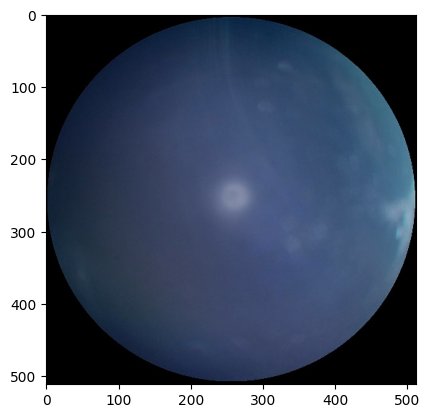

In [27]:
img = df_cat_filenames[342]
image = cv2.imread(os.path.join(img_dir, img))
plt.imshow(image)
print(image.shape)
print(image)

## Crear rejilla de imágenes de ejemplo

A partir de nuestro conjunto de rutas de archivos de imagen de cataratas, vamos a crear una cuadrícula comparativa para ver el aspecto real de las cataratas.  También las convertiremos a una paleta RGB más realista.

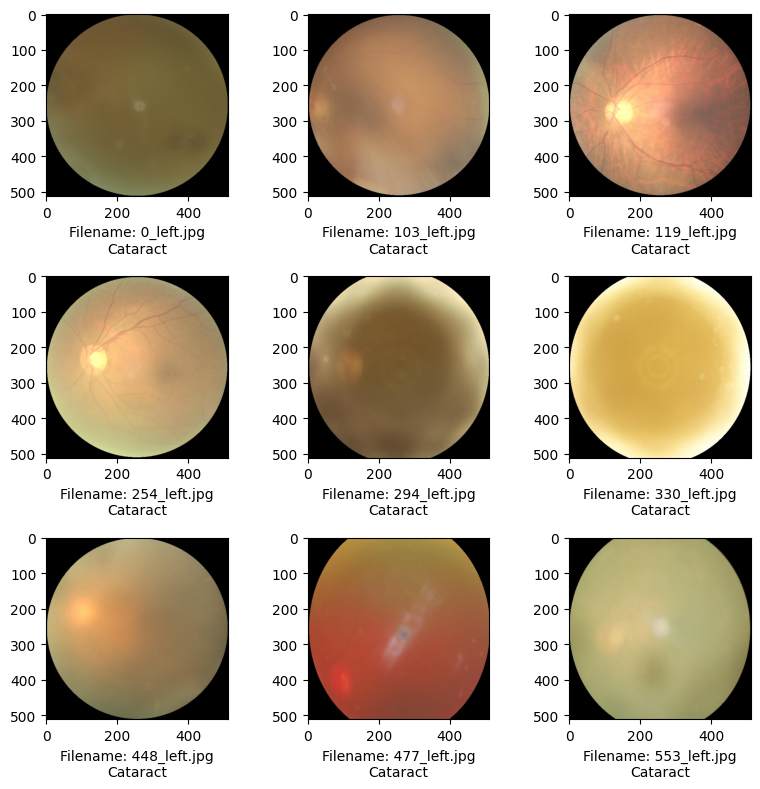

In [32]:
plt.figure(figsize=(8,8))

for i in range(9):
    img = df_cat_filenames[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Cataract'.format(df_cat_filenames[i]))

plt.tight_layout() 

## Reunir las imágenes normales
Ahora tenemos que reunir un conjunto de imágenes normales.  Primero vamos a ver cuántas imágenes normales tenemos disponibles - ya lo hicimos antes pero vamos a echar un vistazo de nuevo.  Recordemos que estamos trabajando con dos ojos y que hemos observado que algunas de las columnas codificadas no tienen datos para ambos ojos, por lo que no se cuenta realmente toda la historia.  Tenemos que mirar el etiquetado en las palabras clave, ya que parece ser la fuente de la verdad cuando se consideran ambos ojos.

In [ ]:
df_data[df_data == 1].sum(axis=0)

ID                              2.0
Patient Age                    28.0
Patient Sex                       0
Left-Fundus                       0
Right-Fundus                      0
Left-Diagnostic Keywords          0
Right-Diagnostic Keywords         0
N                            2101.0
D                            2123.0
G                             397.0
C                             402.0
A                             319.0
H                             203.0
M                             306.0
O                            1588.0
filepath                          0
labels                            0
target                            0
filename                          0
dtype: object

Vemos 2101 resultados codificados como "normal", pero no podemos fiarnos mucho, ya que es posible que no se tengan en cuenta los dos ojos.  Veamos los resultados de palabras clave que contienen "normal", por separado para ambos ojos:

In [ ]:
df_data2.head()

,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords
0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus
1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus
2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy
3,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy
4,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy


In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows

df_left_norm = df_data2[df_data2['Left-Diagnostic Keywords'].str.match('normal')]
print(len(df_left_norm))

2855


In [ ]:
## let's place the Normal data into its own dataframe and print the number of rows

df_rt_norm = df_data2[df_data2['Right-Diagnostic Keywords'].str.match('normal')]
print(len(df_rt_norm))

2735


Por tanto, si sumamos todas estas imágenes, tenemos más de 5.000 imágenes (tanto del ojo izquierdo como del derecho) que se consideran "normales".  Esto es mucho más de lo que tenemos para nuestros datos de "cataratas", que sólo tenían 572 imágenes.  Así que, en ese caso, vamos a seleccionar al azar la misma cantidad de imágenes "normales".

## Combinar ojos normales en un  archivo con su nombre 

In [ ]:
df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)
df_norm_filenames

<ipython-input-34-949d248025f1>:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_norm_filenames = df_left_norm['Left-Fundus'].append(df_rt_norm['Right-Fundus'], ignore_index=True)


0           1_left.jpg
1           8_left.jpg
2           9_left.jpg
3          14_left.jpg
4          15_left.jpg
             ...      
5585    4642_right.jpg
5586    4644_right.jpg
5587    4660_right.jpg
5588    4671_right.jpg
5589    4689_right.jpg
Length: 5590, dtype: object

## Seleccionar y crear un conjunto aleatorio

In [ ]:
## remember we're choosing 572 to equal the number of cataract images we pulled

df_norm_filenames_random = df_norm_filenames.sample(n = 572)
df_norm_filenames_random.head()

## looks like the index is out of order now that we got all the randos

4195    4139_right.jpg
656      2777_left.jpg
3858    3108_right.jpg
1646     1240_left.jpg
2814     4377_left.jpg
dtype: object

In [ ]:
## we will reset the index as well
df_norm_filenames_random = df_norm_filenames_random.reset_index(drop=True)
df_norm_filenames_random

0      4139_right.jpg
1       2777_left.jpg
2      3108_right.jpg
3       1240_left.jpg
4       4377_left.jpg
            ...      
567     2819_left.jpg
568    3253_right.jpg
569    3438_right.jpg
570    2471_right.jpg
571     2417_left.jpg
Length: 572, dtype: object

## Crear una muestra de imágenes "normales"

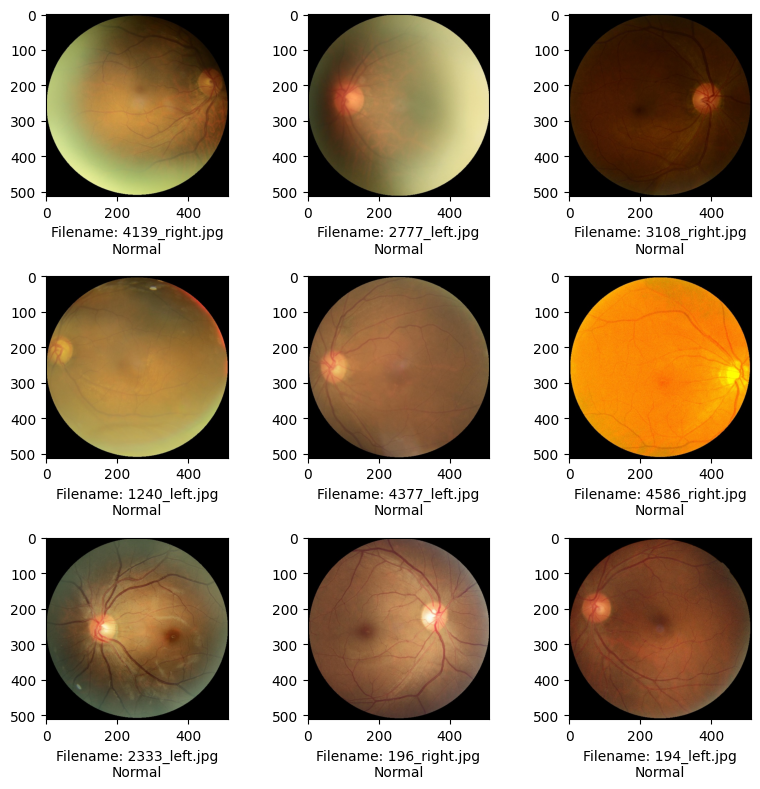

In [ ]:
plt.figure(figsize=(8,8))
for i in range(9):
    img = df_norm_filenames_random[i]
    image = cv2.imread(os.path.join(img_dir, img))

    ## convert image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    ## subplot variables - (# of rows, # of columns, iterate through locations on grid)
    plt.subplot(3,3,i+1)
    plt.imshow(image_rgb)
    
    ## label with filename and diagnosis
    plt.xlabel('Filename: {}\n''Normal'.format(df_norm_filenames_random[i]))

plt.tight_layout()

## Añadir etiqueta de categoría a la lista

Anteriormente creamos estos dos objetos que no eran verdaderos dataframes, se convirtieron en listas después de hacer un append de columnas.  Por conveniencia, necesitamos convertirlos de nuevo en dataframes:

- df_norm_filenames_random
- df_cat_filenames

Las imágenes serán etiquetadas como normales o cataratas, en este caso utilizaremos un generador de datos de imagen que hará la codificación de una sola vez por nosotros, para que podamos preservar las etiquetas de cadena de "palabra" reales.

In [ ]:
df_cat_filenames = pd.DataFrame(df_cat_filenames, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_cat_filenames["label"] = "cataract"

df_cat_filenames.head()

,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract


In [ ]:
df_norm_filenames_random = pd.DataFrame(df_norm_filenames_random, columns = ["filename"])
#df_cat_filenames.set_index("filename", inplace = True)

# add a new column of '1' to the dataframe
df_norm_filenames_random["label"] = "normal"

df_norm_filenames_random.head()

,filename,label
0,4139_right.jpg,normal
1,2777_left.jpg,normal
2,3108_right.jpg,normal
3,1240_left.jpg,normal
4,4377_left.jpg,normal


## Combinar marcos de datos en un único conjunto de datos

Tenemos marcos de datos de cataratas y normales con etiquetas, necesitamos combinarlos para formar un único marco de datos para alimentar nuestro generador de imágenes.


In [ ]:
df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)
df_combined

<ipython-input-40-d381ac5e70cc>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_combined = df_cat_filenames.append(df_norm_filenames_random, ignore_index=True)


,filename,label
0,0_left.jpg,cataract
1,103_left.jpg,cataract
2,119_left.jpg,cataract
3,254_left.jpg,cataract
4,294_left.jpg,cataract
...,...,...
1139,2819_left.jpg,normal
1140,3253_right.jpg,normal
1141,3438_right.jpg,normal
1142,2471_right.jpg,normal


## Aleatorizar nuestro conjunto de datos combinado final

Antes de alimentar este conjunto organizado de imágenes de cataratas y normales, necesitamos aleatorizar las filas que contiene para que cuando entrenemos lo hagamos a partir de un conjunto aleatorio de muestras.

Si añadimos un índice, acabaremos añadiendo una columna para los valores del índice antiguo, por lo que no queremos nuevas columnas, así que eliminaremos el índice antiguo y permitiremos que el nuevo marco de datos tenga uno nuevo.

In [ ]:
df_combined_random = df_combined.sample(frac=1).reset_index(drop=True)
df_combined_random

,filename,label
0,950_left.jpg,normal
1,824_left.jpg,cataract
2,2887_right.jpg,normal
3,2229_left.jpg,cataract
4,215_right.jpg,normal
...,...,...
1139,1454_right.jpg,cataract
1140,2178_left.jpg,cataract
1141,907_left.jpg,cataract
1142,2232_left.jpg,cataract


## Dividir nuestro dataframe en test, train, validation dataframes

Dado que vamos a seguir utilizando un marco de datos con una columna de etiquetas, no podemos utilizar la función común de sklearn test-train-split. en su lugar, simplificaremos las cosas y crearemos tres marcos de datos extrayendo muestras aleatorias y luego excluyendo esas muestras de otro conjunto utilizando el método drop.

In [ ]:
# pull 80% of the combined dataset and reserve it for the training data
# the data generator will automatically create a validation set for us later

df_train = df_combined_random.sample(frac=0.8,random_state=42)
df_train.reset_index(drop=True)

# exclude the 80% that was already chosen, the remaining 20% will go into testing
df_test = df_combined_random.drop(df_train.index)
df_test.reset_index(drop=True)

print(len(df_combined_random))
print(len(df_train))
print(len(df_test))

1144
915
229


## Generador  de imágenes a partir del Dataset
Tenemos un bonito dataframe que hemos creado y Keras combinado con esta práctica función nos permitirá generar imágenes aumentadas y escaladas con el mínimo esfuerzo.  

Aquí añadiremos algunos parámetros que realizarán algunos ajustes a las imágenes.

In [ ]:
train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
            rescale=1./255.,
            validation_split=0.20,
            rotation_range=90,
#            width_shift_range=0.2,
#            height_shift_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            shear_range=0.2,
            brightness_range=[0.3,1]    
#            zoom_range=0.2
            )

## for testing we don't want to do too much augmentation, we'll just scale it.

test_datagen=ImageDataGenerator(rescale=1./255.)

## Convertir las filas de objetos a cadenas

Aunque el flujo desde dataframe funcionará con otros tipos de datos, seguía obteniendo errores que solicitaban convertir las filas del dataframe a tipo string.

In [ ]:
df_train['label'] = df_train['label'].astype(str)
df_test['label'] = df_test['label'].astype(str)

## Crear generadores de imágenes de prueba, entrenamiento y validación

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))

## validation set is created from the training set, 
## we set it at 20% of the training data in the previous code

valid_generator=train_datagen.flow_from_dataframe(
dataframe=df_train,
directory=img_dir,
x_col="filename",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(img_size,img_size))



test_generator=test_datagen.flow_from_dataframe(
dataframe=df_test,
directory=img_dir,
x_col="filename",
y_col="label",
batch_size=32,
#seed=42,
shuffle=False,
class_mode="categorical",
target_size=(img_size,img_size))

Found 732 validated image filenames belonging to 2 classes.
Found 183 validated image filenames belonging to 2 classes.
Found 229 validated image filenames belonging to 2 classes.


## Resultados del generador de imágenes

Veamos los datos reales que se crean a partir del generador de imágenes.  El comando "next" divide los datos del generador en dos matrices numpy - una con los datos de la imagen y otra con los datos de la etiqueta.

In [ ]:
train_image_data, train_labels = train_generator.next()
#train_image_data[0]
train_image_data.shape

(32, 224, 224, 3)

In [ ]:
train_labels[0]

array([1., 0.], dtype=float32)

## Tomemos una sola imagen aumentada

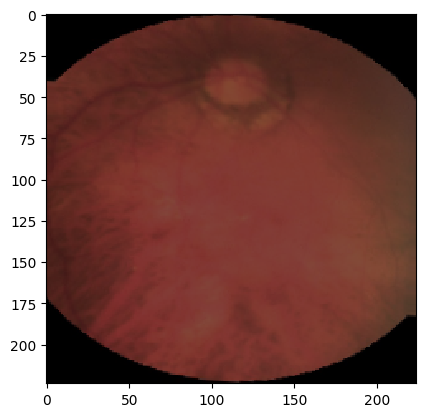

In [ ]:
plt.imshow(train_image_data[0], interpolation='nearest')
plt.show()
#images = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))

## Ejemplos de imágenes aumentadas

Hagamos una cuadrícula de imágenes aumentadas con datos

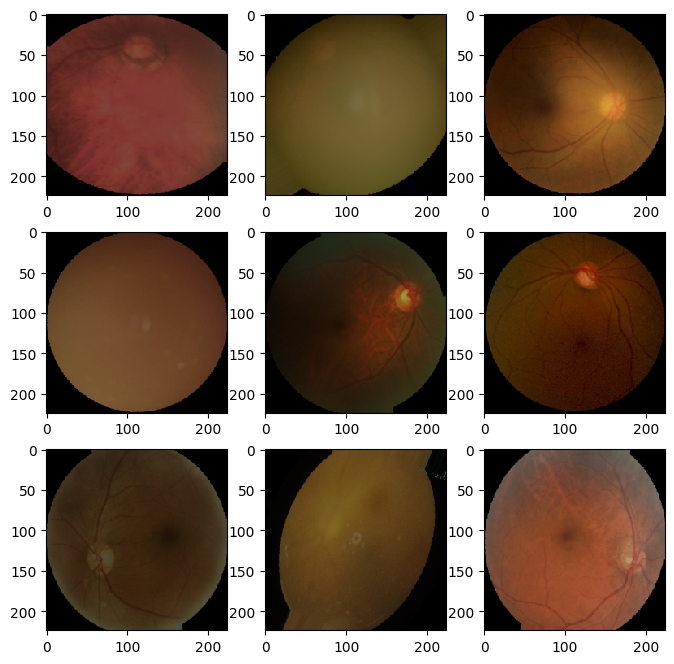

In [ ]:
plt.figure(figsize=(8,8))

for i in range(9):
    plt.subplot(3, 3, i + 1) 
    plt.imshow(train_image_data[i], interpolation='nearest')
    
plt.show() 

## Diagrama del modelo VGG16

![](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

https://neurohive.io/en/popular-networks/vgg16/

## Construir nuestro modelo de aprendizaje por transferencia

Aqui cargamos el modelo vgg16, pero como estamos haciendo aprendizaje de transferencia, no queremos la porcion completamente conectada, asi que la arrancaremos con la opcion include_top FALSE.  No queremos esto porque tenemos un conjunto de datos personalizado que tiene un número personalizado de salidas, 2 en este caso. 

Utilizaremos los pesos 'imagenet' ya que esos filtros / pesos / kernels nos ayudarán a encontrar bordes, esquinas, áreas redondeadas de nuestras imágenes.  Estos ya están incorporados y podemos acelerar el proceso utilizando algunos que han demostrado su eficacia en miles de imágenes.

Eliminaremos el 50% de los perceptrones durante la capa final para evitar el sobreajuste.

También utilizaremos el optimizador de descenso de gradiente ADAM.

In [ ]:
# get VGG16 base model
vgg16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3),
                                       weights='imagenet',
                                       include_top=False)

# add new dense layers at the top
x = keras.layers.Flatten()(vgg16.output)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(128, activation='relu')(x)

## remember we are using 2 outputs only
predictions = keras.layers.Dense(2, activation='softmax')(x)

# define and compile model
model = keras.Model(inputs=vgg16.inputs, outputs=predictions)
for layer in vgg16.layers:
    layer.trainable = False
    
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Crear punto de control y parada anticipada

Un punto de control nos permite monitorizar la acuracidad y realizar alguna tarea, en este caso guardaremos el modelo como un fichero.

La parada temprana monitorizará la precisión para un parámetro 'paciencia' y si no hay mejora se detendrá.

In [ ]:
checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=3, 
                      verbose=1, 
                      mode='auto')


El parámetro steps_per_epoch es el número de lotes de muestras que se necesitan para completar una época. Esto depende del tamaño del lote. El tamaño del lote se establece cuando se inicializan los datos de entrenamiento. Por ejemplo, si estás haciendo esto con ImageDataGenerator.flow() o ImageDataGenerator.flow_from_directory(), el tamaño del lote se especifica con el parámetro batch_size en cada uno de ellos.

Con 3000 muestras por ejemplo:

```
Si el tamaño del lote fuera 100, entonces steps_per_epoch sería 30.
Si el tamaño del lote fuera 10, entonces steps_per_epoch sería 300.
Si el tamaño del lote fuera 1, entonces steps_per_epoch sería 3000.
```

Esto es porque steps_per_epoch debería ser equivalente al número total de muestras dividido por el tamaño del lote. El proceso de implementar esto en Keras está disponible en los dos videos de abajo.

## Constantes para nuestro entrenamiento

SPE es 'pasos por época

n_val_steps es 'número de pasos de validación'

In [ ]:
batch_size = 32
n_spe = train_generator.samples // batch_size
n_val_steps = valid_generator.samples // batch_size
n_epochs = 30

print(n_spe,n_val_steps)

22 5


In [ ]:
hist = model.fit(train_generator,
                        steps_per_epoch=n_spe,
                        validation_data=valid_generator,
                        validation_steps=n_val_steps,
                        epochs=n_epochs,
                        shuffle=True,
                        workers=5,
                        use_multiprocessing=True,
                        callbacks=[checkpoint,early])

Epoch 1/30
22/22 [==============================] - ETA: 0s - loss: 7.7210 - accuracy: 0.5857 
Epoch 1: val_accuracy improved from -inf to 0.80625, saving model to vgg16_1.h5
22/22 [==============================] - 657s 30s/step - loss: 7.7210 - accuracy: 0.5857 - val_loss: 3.0628 - val_accuracy: 0.8062
Epoch 2/30
22/22 [==============================] - ETA: 0s - loss: 2.2388 - accuracy: 0.6971 
Epoch 2: val_accuracy improved from 0.80625 to 0.83750, saving model to vgg16_1.h5
22/22 [==============================] - 665s 30s/step - loss: 2.2388 - accuracy: 0.6971 - val_loss: 1.4023 - val_accuracy: 0.8375
Epoch 3/30
22/22 [==============================] - ETA: 0s - loss: 1.2248 - accuracy: 0.7729 
Epoch 3: val_accuracy did not improve from 0.83750
22/22 [==============================] - 659s 30s/step - loss: 1.2248 - accuracy: 0.7729 - val_loss: 1.0132 - val_accuracy: 0.7750
Epoch 4/30
22/22 [==============================] - ETA: 0s - loss: 0.9963 - accuracy: 0.7414 
Epoch 4: val_

## Cargar nuestro modelo guardado

In [ ]:
from keras.models import load_model
model = load_model('./vgg16_1.h5')

## Graficar la precisión frente a la pérdida

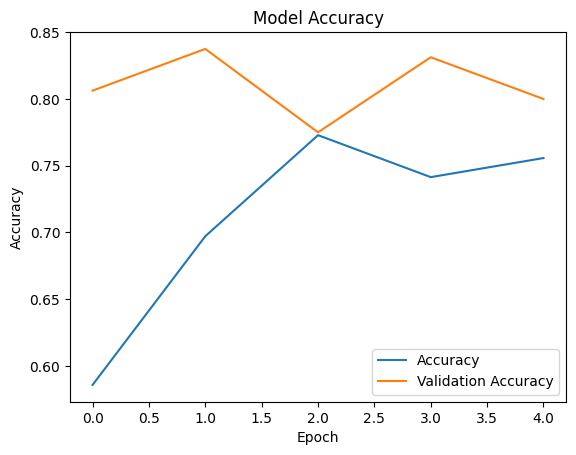

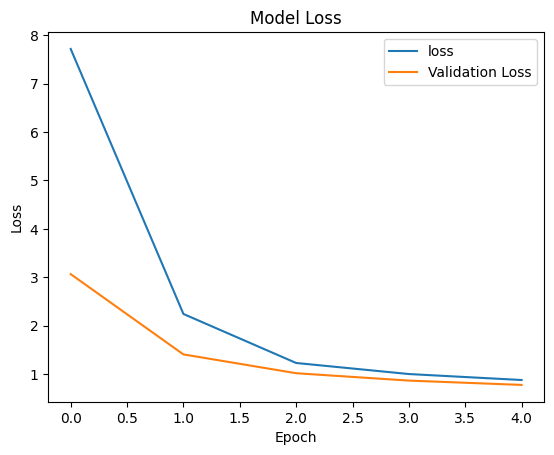

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["loss","Validation Loss"])
plt.show()

## Hacer nuestras predicciones con predict.generator

Tenemos varios generadores que alimentan un tamaño de lote establecido de datos de imagen en lo que queramos, siempre que llamemos al iterador del generador.  Necesitamos reiniciar el generador de prueba para que no estemos alimentando ningún dato de imagen antiguo más adelante.

La predicción de salida es sólo un conjunto de etiquetas categóricas de 0 y 1 - en este caso Catarata es 0 y normal es 1. La predicción de salida NO son datos de imagen.

In [ ]:
test_generator.reset()

In [ ]:
pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


<ipython-input-59-f4d95dc2fe8f>:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model.predict_generator(test_generator,verbose=1,steps=test_generator.samples/batch_size)


7/7 [==============================] - 154s 21s/step


## Datos brutos de predicción

Veamos los resultados del generador de predicciones para comprender mejor la mecánica de los resultados del modelo.

In [ ]:
## let's get the first 10 rows
print(pred[0:10])

[[9.8320770e-01 1.6792275e-02]
 [7.5317163e-04 9.9924684e-01]
 [9.8772568e-01 1.2274357e-02]
 [9.6711284e-01 3.2887220e-02]
 [1.3961974e-01 8.6038029e-01]
 [9.0799624e-01 9.2003822e-02]
 [9.7752255e-01 2.2477342e-02]
 [1.3728708e-01 8.6271292e-01]
 [9.3341422e-01 6.6585749e-02]
 [4.8971281e-04 9.9951023e-01]]


## Convertir datos crudos de predicción

Convirtamos los datos brutos en algo más amigable, 1's y 0's.  ¡Argmax lo hará por nosotros!

In [ ]:
predicted_class_idx=np.argmax(pred,axis=1)

## print the same 10 rows

print(predicted_class_idx[0:10])

[0 1 0 0 1 0 0 1 0 1]


seguimos trabajando con el conjunto completo de etiquetas de nuestro generador

In [ ]:
print(len(predicted_class_idx))

229


## Evaluar la precisión de nuestro modelo

In [ ]:
model.evaluate(test_generator,use_multiprocessing=True,workers=10)

8/8 [==============================] - 171s 20s/step - loss: 1.2805 - accuracy: 0.9170


[1.2804579734802246, 0.9170305728912354]

## Convertir etiquetas de una categoría en etiquetas de texto

1's y 0's son geniales, pero eventualmente vamos a necesitar los nombres de texto reales.

Los generadores tienen montones y montones de parámetros para que usted utilice.

In [ ]:
valid_generator.class_indices.items()

dict_items([('cataract', 0), ('normal', 1)])

Utiliza las claves de nombre de cadena de las etiquetas de entrenamiento (catarata y normal) y convierte las etiquetas de clase predichas codificadas en un punto en nombres de cadena.  Lo que hacen estas líneas es coger el nombre de la categoría (el valor) y colocarlo en la variable de etiquetas predichas donde cumpla los criterios del valor.

In [ ]:
valid_labels = dict((value,key) for key,value in valid_generator.class_indices.items())
pred_labels = [valid_labels[key] for key in predicted_class_idx]

In [ ]:
pred_labels[1:10]

['normal',
 'cataract',
 'cataract',
 'normal',
 'cataract',
 'cataract',
 'normal',
 'cataract',
 'normal']

## Construir un nuevo marco de datos

En realidad no necesitamos hacer esto, pero, la construcción de un nuevo marco de datos puede ser beneficioso si usted necesita hacer cualquier predicción de búsquedas que requieren un marco de datos, o usted podría exportar esto a un CSV.  Es muy útil tenerlo a mano.

In [ ]:
filenames = test_generator.filenames
prediction_df = pd.DataFrame({'Filename': filenames,'Prediction': pred_labels})
prediction_df.head()

,Filename,Prediction
0,824_left.jpg,cataract
1,2901_right.jpg,normal
2,2104_right.jpg,cataract
3,2206_left.jpg,cataract
4,1493_right.jpg,normal


## Verificar los resultados del marco de datos de predicción

Ya que queremos probar que nuestros datos de prueba están siendo efectivamente probados, verifiquemos que nuestros datos de predicción están efectivamente alineados con el nombre del archivo de prueba, la fila y el diagnóstico.

In [ ]:
prediction_df.iloc[35]


Filename      2934_right.jpg
Prediction            normal
Name: 35, dtype: object

Compare esa misma fila con los datos de nuestro generador de pruebas

In [ ]:
print(test_generator.filenames[35])
print(test_generator.labels[35])

2934_right.jpg
1


## Lista de correctos frente a incorrectos

Ahora que hemos verificado ligeramente que nuestros datos de prueba y predicción están alineados, podemos listar todas nuestras predicciones y compararlas con nuestros datos de prueba.  Esto es sólo un ejemplo utilizando un pequeño conjunto de datos de prueba (menos de 1000).  No puedo recomendarlo para un conjunto de datos grande.

In [ ]:
test_file_names=test_generator.filenames  # sequential list of name of test files of each sample
test_labels=test_generator.labels # is a sequential list  of test labels for each image sample
class_dict= test_generator.class_indices # a dictionary where key is the class name and value is the label for the class

print (class_dict) # have a look at the dictionary

new_dict={} 

for key in class_dict: # set key in new_dict to value in class_dict and value in new_dict to key in class_dict
    value = class_dict[key]
    new_dict[value] = key

print('  RESULT  PREDICT      TRUE CLASS       FILENAME ' ) # adjust spacing based on your class names

for i, p in enumerate(pred):
    pred_index=np.argmax(p) # get the index that has the highest probability
    pred_class=new_dict[pred_index]  # find the predicted class based on the index
    true_class=new_dict[test_labels[i]] # use the test label to get the true class of the test file
    file=test_file_names[i]
    
    if true_class == pred_class:
        result = "Correct"
    else:
        result = "Wrong  "
    
    
    print(f' {result}   {pred_class}    {true_class}      {file}')

{'cataract': 0, 'normal': 1}
  RESULT  PREDICT      TRUE CLASS       FILENAME 
 Correct   cataract    cataract      824_left.jpg
 Correct   normal    normal      2901_right.jpg
 Correct   cataract    cataract      2104_right.jpg
 Correct   cataract    cataract      2206_left.jpg
 Correct   normal    normal      1493_right.jpg
 Correct   cataract    cataract      2096_right.jpg
 Correct   cataract    cataract      2113_left.jpg
 Correct   normal    normal      3328_right.jpg
 Wrong     cataract    normal      3146_left.jpg
 Correct   normal    normal      2566_right.jpg
 Correct   cataract    cataract      2156_left.jpg
 Correct   cataract    cataract      2185_left.jpg
 Correct   cataract    cataract      2239_left.jpg
 Correct   cataract    cataract      2146_right.jpg
 Wrong     cataract    normal      2692_left.jpg
 Correct   normal    normal      3221_left.jpg
 Correct   cataract    cataract      1484_left.jpg
 Wrong     cataract    normal      2872_right.jpg
 Correct   normal    n

## Predicción vs rejilla de imágenes de prueba

Estamos trabajando con imágenes, así que veamos los resultados de nuestra predicción frente a las imágenes de prueba.

Tomemos nuestros elementos de datos de prueba, la matriz de imágenes y la categoría de imágenes codificadas.  Empecemos por cambiarles el nombre a algo más amigable.

In [ ]:
test_image_data, test_labels = test_generator.next()

Fíjate en la diferencia de formas de estas matrices.  Las formas deberían darte una pista y darte sentido sobre los datos que contienen.  

La forma de los datos de la imagen estructurada de esta manera:

( NÚMERO DE FILAS, DIMENSIÓN, DIMENSIÓN, PROFUNDIDAD)

Descompongamos la forma:

- En el caso de las imágenes está bastante claro, tenemos 32 muestras recogidas por nuestro generador de pruebas
- 224 en la dimensión horizontal de la imagen
- 224 en la dimensión vertical de la imagen
- 3 de profundidad, ya que se trata de una imagen en color

Mientras que los datos de las etiquetas están estructurados así

- 32 muestras
- 2 de profundidad ya que tenemos 2 salidas, la probabilidad numérica de cada una de nuestras categorías

In [ ]:
print(test_image_data.shape)
print(test_labels.shape)

(32, 224, 224, 3)
(32, 2)


En nuestra cuadrícula nos gustaría ver algunos parámetros como nombre de archivo, etiqueta y valor categórico (1, 0).

Probemos la salida de esos parámetros desde los generadores

In [ ]:
z = 0
#test filename

test_file_names=test_generator.filenames[z]
print(test_file_names)

test_labels_example=test_generator.labels[z]
print(test_labels_example)

pred_labels[z]

824_left.jpg
0


'cataract'

z = 0
#nombre_archivo_prueba

nombre_archivo_prueba=nombre_archivo_prueba[z]
print(nombres_archivo_prueba)

prueba_etiquetas_ejemplo=prueba_generador.etiquetas[z]
print(etiquetas_prueba_ejemplo)

pred_etiquetas[z]

In [ ]:
test_labels[5]

array([1., 0.], dtype=float32)

Convierte nuestras tuplas de etiquetas de prueba en un único array unidimensional con argmax.

Está claro que el array completo de etiquetas de prueba tiene sólo 32 elementos, ya que éste es el límite de tamaño de lote que se estableció en los parámetros del generador.

In [ ]:
test_class_idx=np.argmax(test_labels,axis=1)
#test_class_idx[4]
test_class_idx

array([0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 1, 0, 1, 0, 0, 1])

## Trazar nuestra cuadrícula de comparación

El generador de datos codificó nuestras categorías por nosotros, por lo que catarata = 0 y normal = 1.  Como estamos utilizando generadores de imágenes, sólo podremos reunir 32 imágenes a la vez, ya que éste es el tamaño de lote que hemos establecido.  Si aumentamos el tamaño del lote, el generador recogerá más imágenes y las enviará a través de la función de ajuste durante el entrenamiento.

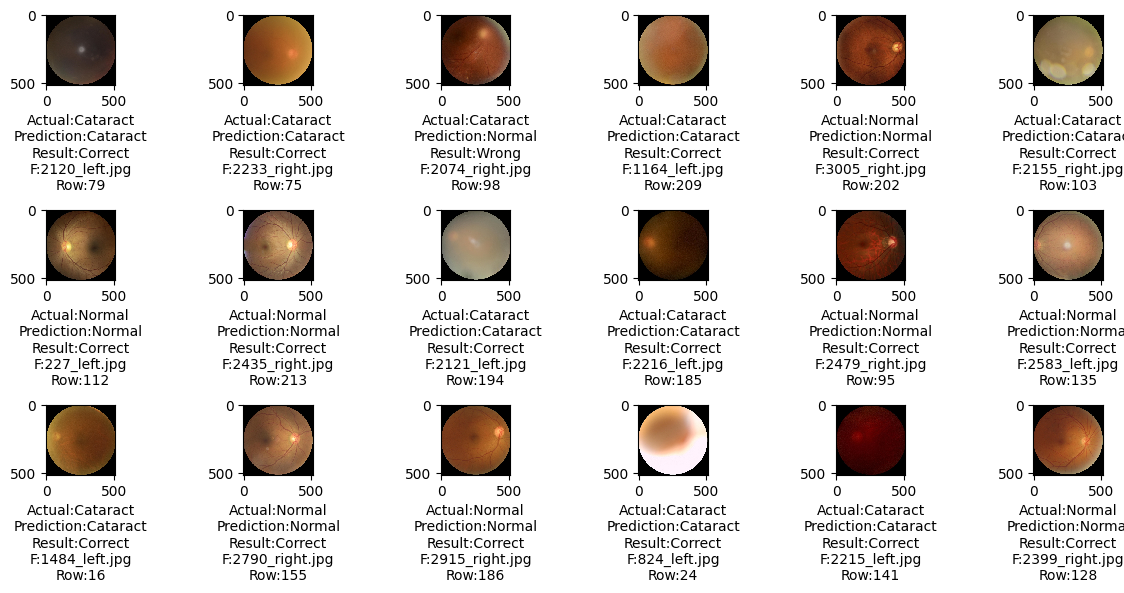

In [ ]:
plt.figure(figsize=(12,6))
for i in range(18):
    sample = random.choice(range(test_generator.samples))
#    print(str(sample))
    img = test_generator.filenames[sample]
    image = cv2.imread(os.path.join(img_dir, img))
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    category = test_generator.labels[sample]
    pred_category = pred_labels[sample]

#    sample = random.choice(range(0,test_generator.samples))    
#    image = test_image_data[sample]
#    category = test_class_idx[sample]
#    pred_category = pred_labels[sample]
           
    
    if category== 1:
        label = "Normal"
    else:
        label = "Cataract"
        
    if pred_category== "normal":
        pred_label = "Normal"
    else:
        pred_label = "Cataract"

    if label == pred_label:
        result = "Correct"
    else:
        result = "Wrong"

        
    plt.subplot(3,6,i+1)
    plt.imshow(image_rgb, interpolation='nearest')
    plt.xlabel("Actual:{}\nPrediction:{}\nResult:{}\nF:{}\nRow:{}".format(label,
                                                                          pred_label,
                                                                          result,
                                                                          test_generator.filenames[sample],
                                                                          sample))
plt.tight_layout() 

## Reporte de clasificación

In [ ]:
print('Classification Report')
target_names = ['Cataract', 'Normal']
print(classification_report(test_generator.classes, predicted_class_idx, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

    Cataract       0.90      0.92      0.91       106
      Normal       0.93      0.91      0.92       123

    accuracy                           0.92       229
   macro avg       0.92      0.92      0.92       229
weighted avg       0.92      0.92      0.92       229



## Matriz de confusión

Una matriz de confusión es una FORMA EXTREMADAMENTE ÚTIL de mostrar la cantidad de predicciones correctas frente a las incorrectas.  Pero la matriz de confusión en bruto es una matriz bastante básica.  Esto se puede trazar para que sea mucho más fácil de leer.

In [ ]:
cm = confusion_matrix(test_generator.labels, predicted_class_idx)
print('Confusion Matrix')
cm

Confusion Matrix


array([[ 98,   8],
       [ 11, 112]])

## Graficar matriz de confusión

In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['cataract','normal']

Podemos ver que el eje y son las etiquetas verdaderas (de prueba) y el eje x es la salida predicha.  

Los elementos correctos son aquellos en los que coinciden las celdas verdaderas y las predichas: las categorías son similares, en este caso, un color más oscuro.

Los elementos incorrectos son de color más claro y se encuentran donde las celdas verdaderas y las predichas tienen categorías diferentes.

Confusion matrix, without normalization
[[ 98   8]
 [ 11 112]]


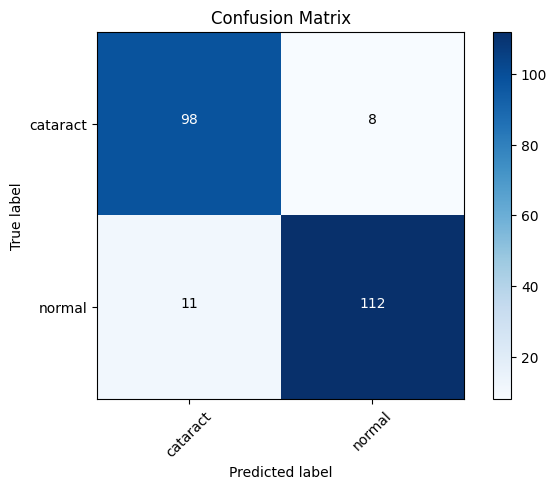

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')